----

# <center>Анализ коммерческого успеха игр. </center> 
### Определение зависимости продаж от жанра, платформы, оценки пользователей и пр.  Построение прогноза на следующий год.
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й.

**Дальше мы увидим:** 
- Сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Как менялись продажи по платформам. Платформы с наибольшими суммарными продажами и распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
- График по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? 
- Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 
- Общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

## Шаг 1. Загружаем файл с данными и изучаем общую информацию

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [9]:
data = pd.read_csv('datasets/games.csv')

In [10]:
display(data.head())
data.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Шаг 2. Подготовка данных

In [11]:
# Переименуем столбцы
data.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

# Удалим две записи, в которых нет названия игры. В них также нет иформации о жанре и оценках. 
# Вряд ли мы сможем получить какую-то пользу от таких записей.
data.dropna(subset=['name'], inplace=True)

# В двух процентах строк не указана дата релиза.
# Совсем немного информации можно взять из названия игры. Если в названии год указан добавим его.
data.loc[data['year_of_release'].isnull(),'year_of_release'] = \
        data[data['year_of_release'].isnull()] \
        ['name'].str.findall('\d\d\d\d').apply(
        lambda x: float(''.join(x)) if x else float('NaN'))

# Остальные пропуски удалим и поменяем формат на целые числа.
data.dropna(subset=['year_of_release'], inplace=True)
data['year_of_release'] = data['year_of_release'].astype('int')
# У нас остаются только пропуски в рейтинге игр и оценках. Пока оставим это как есть.

# Разобьем оценки критиков на 10 равных групп
quantiles = list(data['critic_score'].quantile([i / 10 for i in range(11)]))
quantiles = sorted([int(i) for i in quantiles], reverse=True)

# Функция для деления на группы
def critic_score_grouping(critic_score):
    if critic_score != critic_score:
        return 'no_information'
    for i in range(1, len(quantiles)):
        if critic_score >= quantiles[i]:
            return str(quantiles[i]) + '-' + str(quantiles[i-1])
# Само деление
data['critic_score_grouped'] = data['critic_score'].apply(critic_score_grouping)


# В столбще оценки пользователей много строк имеет значение 'tbd', если погуглить, это означает, что 
# оценок было меньше четырех. Получается у нас два не числовых значения - нет данных и мало оценок.
# Отметим строки 'tbd' как -1, что бы отделить их от пропусков и перевести все в формат float
data.loc[data['user_score'] == 'tbd','user_score'] = -1
data['user_score'] = data['user_score'].astype('float')

# Разобьем оценки пользователей на 10 равных групп
quantiles = list(
    data.query('user_score != -1 and user_score == user_score')
    ['user_score'].quantile([i / 10 for i in range(11)])
                )
quantiles = sorted([float(i) for i in quantiles], reverse=True)

# Функция для деления на группы
def user_score_grouping(user_score):
    if user_score != user_score:
        return 'no_information'
    if user_score == -1:
        return 'less_than_four_marks'
    for i in range(1, len(quantiles)):
        if user_score >= quantiles[i]:
            return '{:.1f}-{:.1f}'.format(quantiles[i], quantiles[i-1])
# Само деление
data['user_score_grouped'] = data['user_score'].apply(user_score_grouping)

# Добавим поле с общей выручкой 
data['total_sales'] = (data['na_sales'] + data['eu_sales']  + 
                       data['jp_sales']  + data['other_sales'])

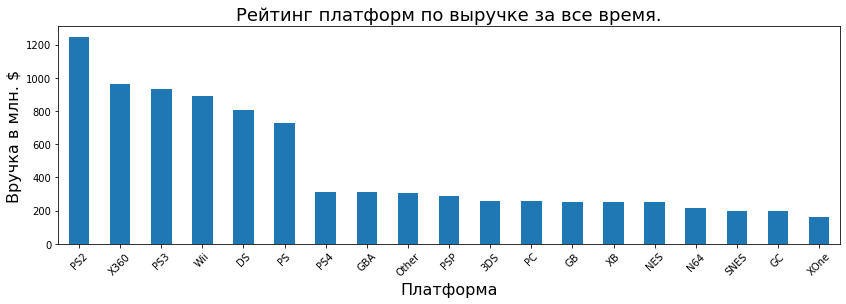

In [12]:
# На графике видно что можно взять первые 6 платформ, но тогда не попадут PS4 и Xbox One
# Прийдется брать первые 18 платформ
best_sellers = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
# best_sellers.plot.bar(figsize=(12,4), rot=45)
# plt.title('Рейтинг платформ по выручке за все время.', fontsize=18)
# plt.ylabel('Вручка в млн. $', fontsize=16)
# plt.xlabel('Платформа', fontsize=16)
# plt.show()
# Добавим поле со сгруппированными данными по платформе
best_sellers = list(best_sellers.head(18).index)
data['platform_grouped'] = data['platform'].apply(
    lambda x: x if x in best_sellers else 'Other'
                                                  )
best_sellers_grouped = \
    data.groupby('platform_grouped')['total_sales'].sum().sort_values(ascending=False)
best_sellers_grouped.plot.bar(figsize=(14,4), rot=45)
plt.title('Рейтинг платформ по выручке за все время.', fontsize=18)
plt.ylabel('Вручка в млн. $', fontsize=16)
plt.xlabel('Платформа', fontsize=16)
plt.show()

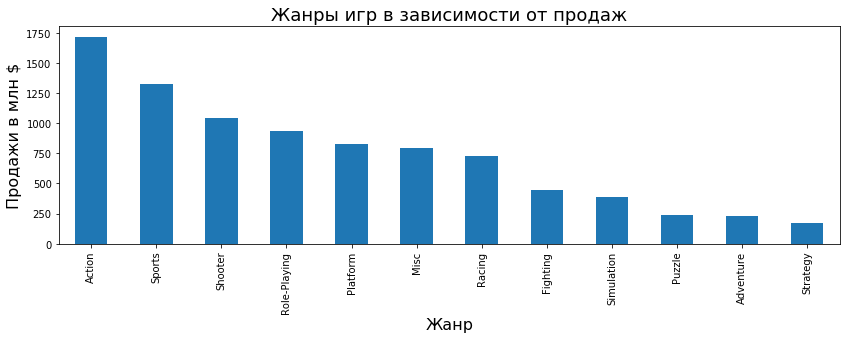

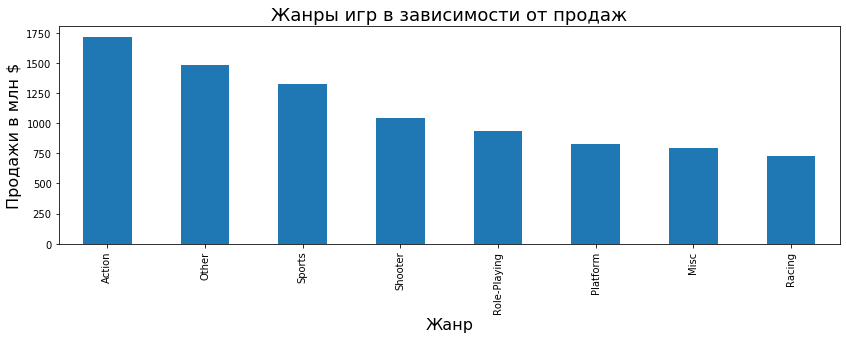

In [13]:
#  Сгруппируем жанры
best_genres = data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
best_genres.plot.bar(figsize=(14,4))
plt.title('Жанры игр в зависимости от продаж', fontsize=18)
plt.ylabel('Продажи в млн $', fontsize=16)
plt.xlabel('Жанр', fontsize=16)
plt.show()
# Оставим 7 популярных жанров остальные объединим
best_genres = list(best_genres.head(7).index)
data['genres_grouped'] = data['genre'].apply(lambda x: x if x in best_genres else 'Other')
grouped_genre = data.groupby('genres_grouped')['total_sales'].sum()
grouped_genre.sort_values(ascending=False).plot.bar(figsize=(14,4))
plt.title('Жанры игр в зависимости от продаж', fontsize=18)
plt.ylabel('Продажи в млн $', fontsize=16)
plt.xlabel('Жанр', fontsize=16)
plt.show()

## Шаг 3. Исследовательский анализ данных

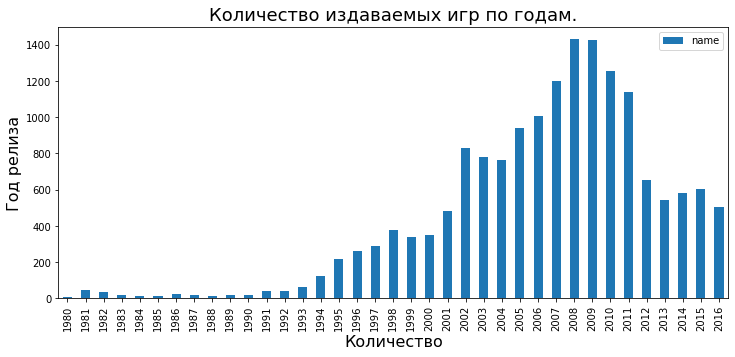

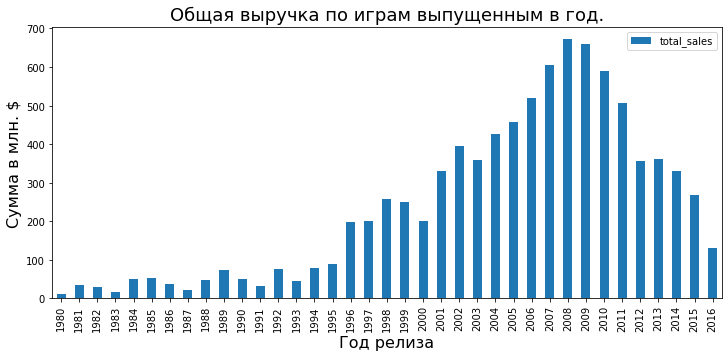

In [14]:
# Посчитаем сколько выпускается игр каждый год
gemes_per_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
# Построим график
gemes_per_year.plot.bar(figsize=(12,5))
plt.title('Количество издаваемых игр по годам.', fontsize=18)
plt.xlabel('Количество', fontsize=16)
plt.ylabel('Год релиза', fontsize=16)
plt.show()

# Посчитаем годовую выручку сгруппированную по году выпуска игры
gemes_per_year = data.pivot_table(index='year_of_release',
                                  values='total_sales', aggfunc='sum')
# Построим график
gemes_per_year.plot.bar(figsize=(12,5))
plt.title('Общая выручка по играм выпущенным в год.', fontsize=18)
plt.xlabel('Год релиза', fontsize=16)
plt.ylabel('Сумма в млн. $', fontsize=16)
plt.show()

### Вывод

Что вы видем на графиках:
1. Количество выпускаемых игр до 1995 года было сильно меньше чем после, поэтому этим перидом можно принебречь.
2. С 2002 по 2011 годы был значительный всплеск новых игр, а с 2012 года график вернулся к уровню 2001-2002 года и рост стал более умеренным.
3. Выручка по играм выпущенным в 2016 и 2015 год, несколько ниже 2013 и 2014. Можно преположить что игра собирает выручку не только в год своего выпуска, но и в последующие годы. Возможно выручка по этим играм стенет выше еще за счет продаж в последующие годы.

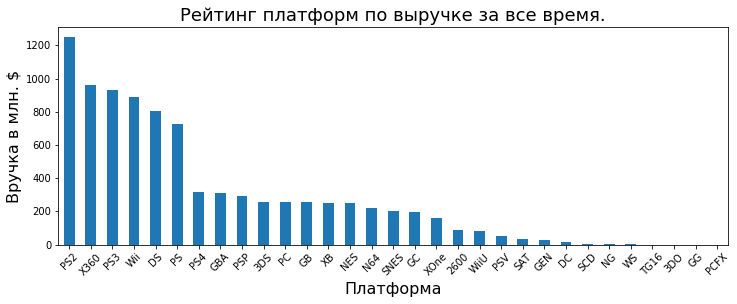

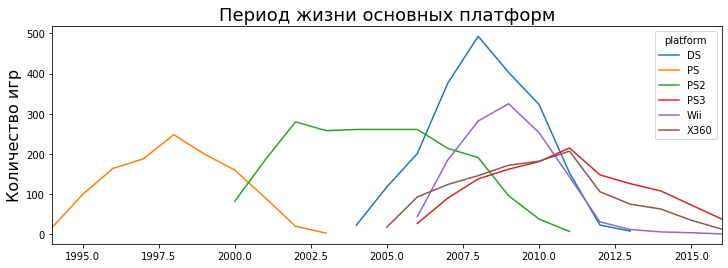

In [15]:
# Посмотрим на платформы с самой большой выручкой
best_sellers = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
best_sellers_list = list(best_sellers.head(6).index)
best_sellers.plot.bar(figsize=(12,4), rot=45)
plt.title('Рейтинг платформ по выручке за все время.', fontsize=18)
plt.ylabel('Вручка в млн. $', fontsize=16)
plt.xlabel('Платформа', fontsize=16)
plt.show()

# Выберем шесть самых популярных платформ и посмотрим средний срок жизни платформы
best_sellers_data = data.query('platform in @best_sellers_list and year_of_release > 1993')
best_sellers_data = best_sellers_data.pivot_table(
    index='year_of_release', values='name', columns='platform', aggfunc='count')
# График жизни основных платформ
best_sellers_data.plot(figsize=(12,4))
plt.title('Период жизни основных платформ', fontsize=18)
plt.ylabel('Количество игр', fontsize=16)
plt.xlabel('', fontsize=16)
plt.show()

### Вывод
Мы можем примерно понять что платформа живет порядка семи - десяти лет, при чем первую свою половину жизни на платформе идет рост новых игр, а во второую почти в таком же темпе идет убывание.

Одна из наших конечных задач - выбрать перспективные платформы для разработки игр на следующий год. Если выбрать новые платформы, то мы получим в перспективе еще 10 лет, однако рискуем выбрать платформы, которые не будут популярными. Выбирать платформы, которым уже 10 лет тоже нехочется, понятно почему. Наша задача найти ту самую золотую середину, так что продолжим поиск.

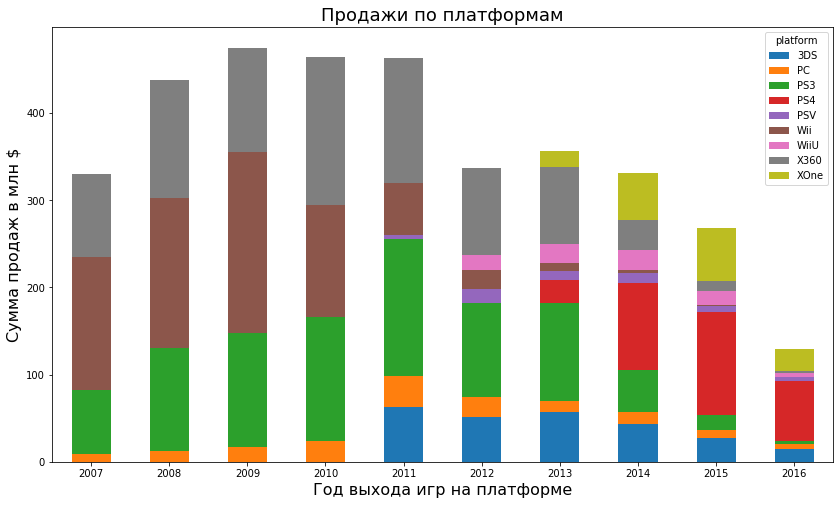

In [16]:
# Оставим в нашей выборке данные за последние 10 лет, что бы увидеть динамику близкого к нам периода
actual_data = data.query('year_of_release > 2006')
actual_data = actual_data.pivot_table(
    index='platform', values='total_sales',
    columns='year_of_release', aggfunc='sum')
actual_data = actual_data.fillna(0)
# Выберем только те платформы, которые в 2016 еще имели выручку, что бы исключить ушедшие платформы.
actual_data = actual_data[actual_data[2016] > 0]
# Транспонируем датасет что бы удобней было строить график.
actual_data = actual_data.T
actual_data.plot(kind='bar',figsize=(14,8), stacked=True, rot=0)
plt.title('Продажи по платформам', fontsize=18)
plt.xlabel('Год выхода игр на платформе', fontsize=16)
plt.ylabel('Сумма продаж в млн $', fontsize=16)
plt.show()

### Вывод
Из этого графика можно сделать следующие выводы:
1. Доля PS3 замещается PS4
2. Доля X360 замещается XOne
3. А вот у Nintendo с заменой поколений проблемы. Доля Wii упала, а вот выручка у WiiU растет слабо.
4. К нашему 2016 году у 3DS еще есть продажи, но платформе уже 6 лет и она идет на спад.
5. Доля PC всегда была не очень высокой.
6. PSV как замена PSP тоже дает выручку, не такую большую как PS4 однако сравнимую с PC

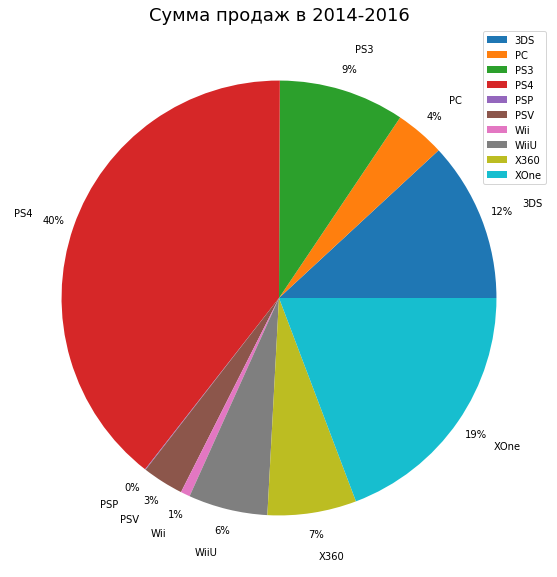

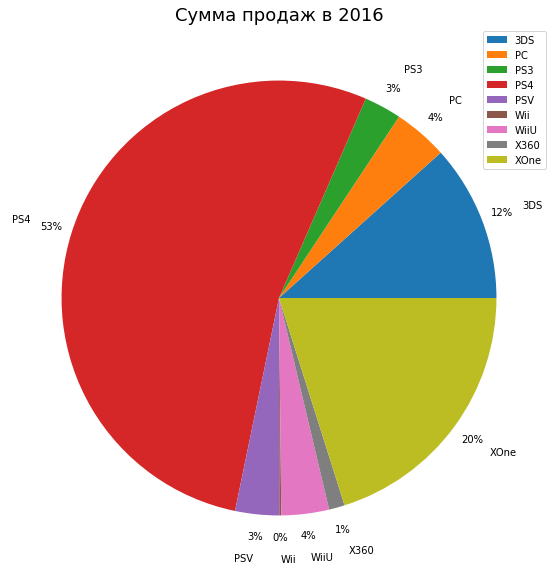

In [17]:
# Отдельно посмотрим на доли рынка платфор за последние три года в сумме
# Оставим в нашей выборке данные за последние 3 года, что бы выбрать интересные для нас платформы
three_year_data = data.query('year_of_release > 2013')
three_year_data = three_year_data.pivot_table(
    index='platform', values='total_sales', aggfunc='sum')
# Заполним пропуски нулями
three_year_data = three_year_data.fillna(0)

# Построим график
three_year_data.plot(subplots=True, kind='pie',figsize=(10,10),
                     autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.title('Сумма продаж в 2014-2016', fontsize=18)
plt.ylabel('')
plt.show()

# Сделаем тоже самое за текущий год
one_year_data = data.query('year_of_release > 2015')
one_year_data = one_year_data.pivot_table(
    index='platform', values='total_sales', aggfunc='sum')
# Заполним пропуски нулями
one_year_data = one_year_data.fillna(0)

# Построим график
one_year_data.plot(subplots=True, kind='pie',figsize=(10,10),
                     autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.title('Сумма продаж в 2016', fontsize=18)
plt.ylabel('')
plt.show()

### Выводы
На данном этапе вырисовываются потенциальные платформы на следующий 2017 год.

**Самые приоритетные платформы:**
- PS4 - топовая платформа от Sony которая в самом рассвете
- XOne - основной конкурент от Microsoft, второй по выручку на рынке.

**Платформы второго порядка:**
- 3DS - платформа все еще с хорошей выручкой, однако она на рынке шестой год, что повышает вероятность заката платформы.
- PC - дает не очень высокую выручку относительно лидеров рынка, но плюс этой платформы в том, что она более стабильная в плане потери актуальности. То есть мало, но стабильно.

**Платформы третьего порядка.** Эти платформы можно исмользовать только если цель собрать максимальную выручку с рынка без учета эффективности. Хотя прагматичнее обойти эти платформы стороной.
- PSV и WiiU платформы нишевые - это портативные приставки. На них есть свой спрос, однако он не самый большой. 
- PS3 и X360 эти платформы находятся на закате.


**Гавный вывод в том, что PS4 b XOne собрали за 2016 годя 70% всей выручки.**

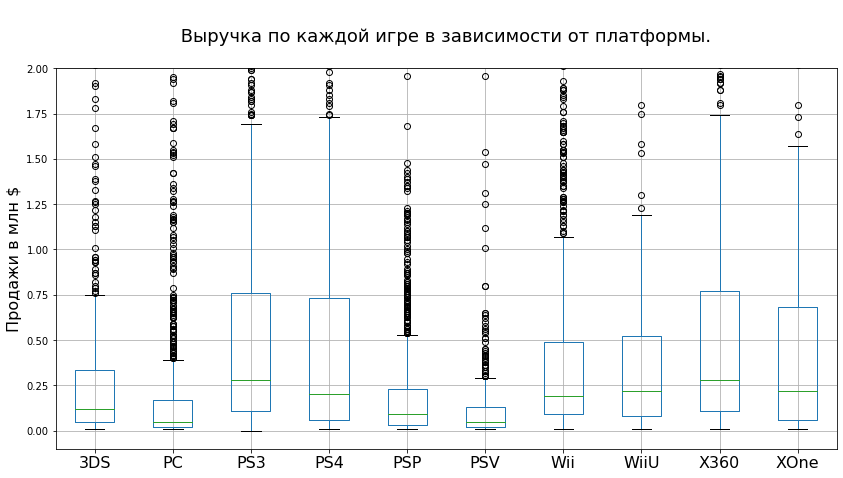

In [30]:
# Сделаем список актуальных платформ. Возьмеме те на которых с 2015 года выпускались игры.
interest_platforms = list(data.query('year_of_release > 2013')['platform'].unique())

# Сформируем датасет только по актуальным платформам
good_data = data.query('platform in @interest_platforms')

# Посчитаем выручку игры по каждой платформе
good_data_pvt = good_data.pivot_table(index='name', columns='platform',
                                      values='total_sales', aggfunc='sum')
# Построим график ящик с усами
good_data_pvt.boxplot(figsize=(14,7))
plt.ylim(-0.1,2)
plt.title('\n Выручка по каждой игре в зависимости от платформы. \n', fontsize=18)
plt.ylabel('Продажи в млн $', fontsize=16)
plt.xlabel('', fontsize=16)
plt.xticks(fontsize=16)
plt.show()

### Вывод
Если вы хотите продавать дорогие игры вам дорога в PlayStation или XBox. PS4, PS3, X360, XOne, имеют самый большой средний чек.

Дальше идут Nintendo со своими Wii, WiiU и 3DS. 

Последние по среднему чеку PC и PSV.

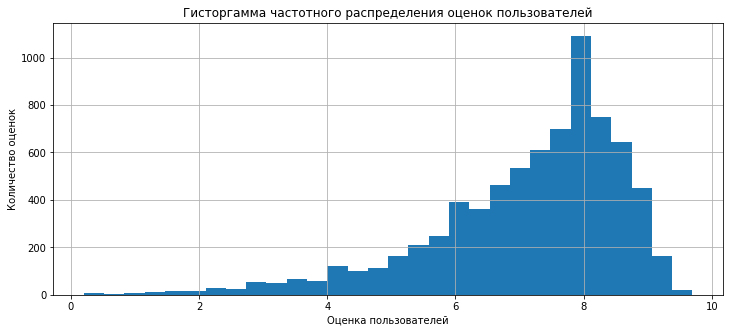

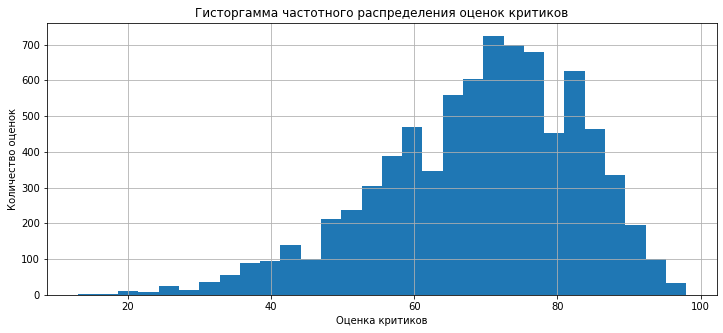

In [19]:
# Давайте посмотрим как выглядят оценки пользователей
data[data['user_score'] > 0]['user_score'].hist(bins=30, figsize=(12,5))
plt.title('Гисторгамма частотного распределения оценок пользователей')
plt.ylabel('Количество оценок')
plt.xlabel('Оценка пользователей')
plt.show()

# Сгруппируем данные по оценкам критиков
data['critic_score'].hist(bins=30, figsize=(12,5))
plt.title('Гисторгамма частотного распределения оценок критиков')
plt.ylabel('Количество оценок')
plt.xlabel('Оценка критиков')
plt.show()

Гистограммы выглядат вполне нормально.

,total_sales,user_score,critic_score
total_sales,1.0,0.131405,0.221695


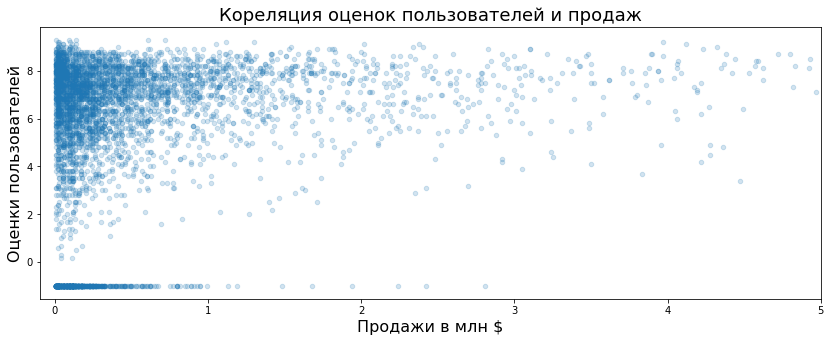

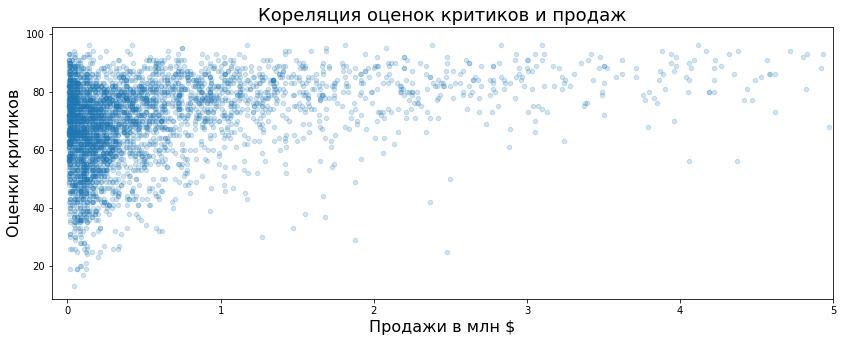

In [20]:
# Посмотрим на кореляцию оценок и продаж по каждой игре
display(good_data.loc[:,['total_sales','user_score', 'critic_score']].corr().head(1))
# Посмотрим это же на графиках
good_data.plot.scatter(x='total_sales',y='user_score', figsize=(14,5), alpha=0.2)
plt.title('Кореляция оценок пользователей и продаж', fontsize=18)
plt.ylabel('Оценки пользователей', fontsize=16)
plt.xlabel('Продажи в млн $', fontsize=16)
plt.xlim(-0.1,5)
plt.show()
good_data.plot.scatter(x='total_sales',y='critic_score', figsize=(14,5), alpha=0.2)
plt.title('Кореляция оценок критиков и продаж', fontsize=18)
plt.ylabel('Оценки критиков', fontsize=16)
plt.xlabel('Продажи в млн $', fontsize=16)
plt.xlim(-0.1,5)
plt.show()

### Вывод

Незьзя сказать что кореляция приямая и однозначная, но некоторая кореляция все же есть. При этом кореляция с оценками критиков получается в два раза больше чем кореляция с оценками пользователей. Интересно, может ли это быть связано с тем, что критики являются лидерами мнений, а также чаще всего раньше получают игру и своими отзывами влият на продажи?

По тем играм где у нас оценок пользователей было мало (мы из отметили со значением -1) мы видим что и продажи таких игр не очень большие

Ну и если отдельно посмотреть на игры с большой выручкой то чаще всего по этим играм будет высокой как оценка критиков так и оценка пользователей.

,total_sales,user_score,critic_score
total_sales,1.0,0.02911,0.406568


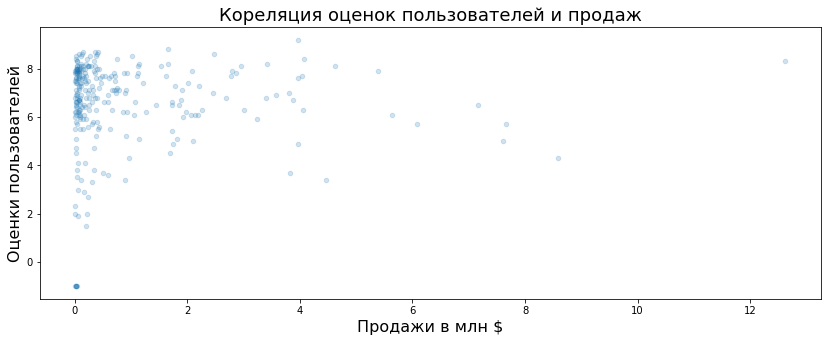

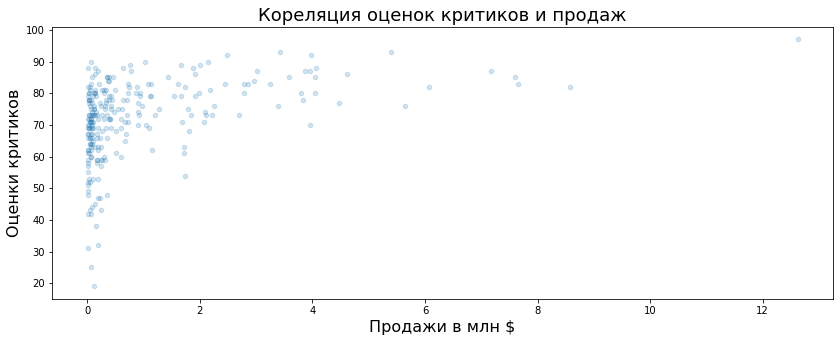

In [21]:
# А что если посмотреть на эти же данные но только по самой популярной платформе
ps4_good_data = good_data[good_data['platform'] == 'PS4']
display(ps4_good_data.loc[:,['total_sales','user_score', 'critic_score']].corr().head(1))
# Посмотрим это же на графиках
ps4_good_data.plot.scatter(x='total_sales',y='user_score', figsize=(14,5), alpha=0.2)
plt.title('Кореляция оценок пользователей и продаж', fontsize=18)
plt.ylabel('Оценки пользователей', fontsize=16)
plt.xlabel('Продажи в млн $', fontsize=16)
# plt.xlim(-0.1,5)
plt.show()
ps4_good_data.plot.scatter(x='total_sales',y='critic_score', figsize=(14,5), alpha=0.2)
plt.title('Кореляция оценок критиков и продаж', fontsize=18)
plt.ylabel('Оценки критиков', fontsize=16)
plt.xlabel('Продажи в млн $', fontsize=16)
# plt.xlim(-0.1,5)
plt.show()

### Вывод
По самой популярной платформе последний лет PS4 - кореляция значительно выше. И по-прежнуму оценки критиков больше коррелируют с продажами. Игры которые без оценок, это игры которые почти никто не покупет.

- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?


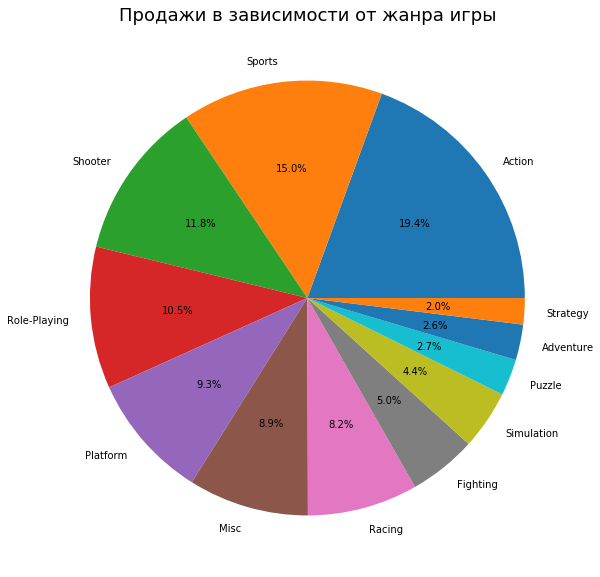

In [22]:
# Как влияет на продажи жанр игры
genres = data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
genres.plot.pie(figsize=(10,10), autopct='%.1f%%')
plt.title('Продажи в зависимости от жанра игры', fontsize=18)
plt.ylabel('')
plt.show()

### Вывод
Четыре жанра занимают больше половины всех продаж. А 7 самых популярных жанров получают 80% всей выручки.

## Шаг 4. Составление портрета пользователя каждого региона

- Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

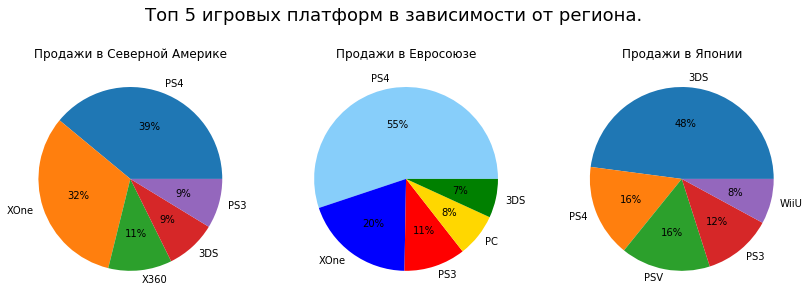

In [31]:
# Возьмем данные за актуальный для нас период. Это 10 лет с учетом того,
# что срок жизни платформы около десяти лет.
actual_data = data.query('year_of_release > 2013')
actual_data_pvt = actual_data.pivot_table(
    index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum'
)

# Построим график 5 топ платформ по каждому региону

na_data = actual_data_pvt['na_sales'].sort_values(ascending=False).head(5)
eu_data = actual_data_pvt['eu_sales'].sort_values(ascending=False).head(5)
jp_data = actual_data_pvt['jp_sales'].sort_values(ascending=False).head(5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(14,5)
fig.suptitle("Топ 5 игровых платформ в зависимости от региона.", fontsize=18)
colors = ['lightskyblue', 'blue', 'red', 'gold', 'green']
ax1.pie(na_data, autopct='%1.0f%%', labels=na_data.index)
ax1.set_title('Продажи в Северной Америке')
ax2.pie(eu_data, autopct='%1.0f%%', labels=eu_data.index, colors=colors)
ax2.set_title('Продажи в Евросоюзе')
ax3.pie(jp_data, autopct='%1.0f%%', labels=jp_data.index)
ax3.set_title('Продажи в Японии')
plt.show()

<font color=brown>Я бы все же предпочел здесь придерживаться нашего периода начиная с 13-14 года. Обрати внимание, в наших отчетах топ места занимают устаревшие платформы. Стал бы ты показывать эти таблицы менеджеру магазина и рекомендовать делать упор на X360 или Wii в 2017м?  
Такие же устаревшие данные будут по жаровым предпочтениям.

### Вывод
Ничего себе, оказывается еще в каждом регионе свои предпочтения по платформам. То что хорошо в Америке в Японии даже в топ 5 не войдет.

Ну и да, некоторый патриотизм тут тоже проглядывается, американцы предпочитают Microsoft, японцы Nintendo и Sony, и только нам европейцам приходится безпристрастно выбирать лучшее)

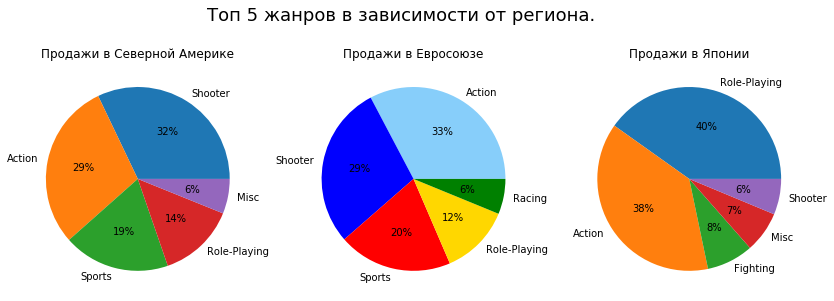

In [34]:
# Проделаем тоже самое с жанрами игр
actual_data = data.query('year_of_release > 2013')
actual_data_pvt = actual_data.pivot_table(
    index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum'
)

# Построим график 5 топ платформ по каждому региону
na_data = actual_data_pvt['na_sales'].sort_values(ascending=False).head(5)
eu_data = actual_data_pvt['eu_sales'].sort_values(ascending=False).head(5)
jp_data = actual_data_pvt['jp_sales'].sort_values(ascending=False).head(5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(14,5)
fig.suptitle("Топ 5 жанров в зависимости от региона.", fontsize=18)
colors = ['lightskyblue', 'blue', 'red', 'gold', 'green']
ax1.pie(na_data, autopct='%1.0f%%', labels=na_data.index)
ax1.set_title('Продажи в Северной Америке')
ax2.pie(eu_data, autopct='%1.0f%%', labels=eu_data.index, colors=colors)
ax2.set_title('Продажи в Евросоюзе')
ax3.pie(jp_data, autopct='%1.0f%%', labels=jp_data.index)
ax3.set_title('Продажи в Японии')
plt.show()

### Вывод
В отличии от платформ, с жанрами Европа и Америка очень схожи. Отличается только Япония.

Экшн популярен везде а вот вместо спорта и шутеров в Японии больше популярен жанр ролевых игр.

In [25]:
actual_data_pvt

,eu_sales,jp_sales,na_sales
genre,,,
Action,350.95,102.07,530.50
Adventure,37.90,29.53,61.52
Fighting,43.65,28.61,95.88
Misc,146.88,64.53,285.06
Platform,81.62,35.20,134.25
Puzzle,27.77,12.43,42.49
Racing,113.43,13.24,132.93
Role-Playing,110.62,170.38,199.63
Shooter,238.89,19.35,373.13


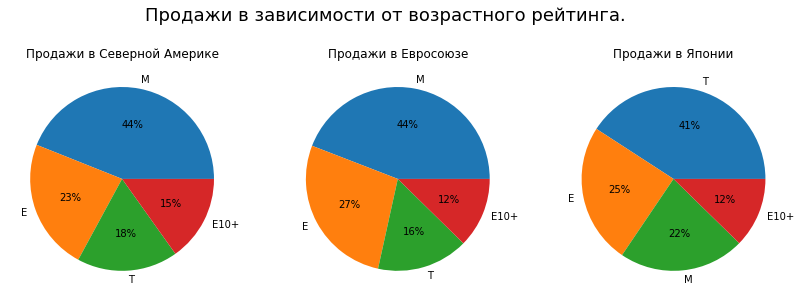

In [35]:
# Посмотрим как влияет на продажи возрастной рейтинг
actual_data = data.query('year_of_release > 2013')
actual_data_pvt = actual_data.pivot_table(
    index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum'
)

# В возрастном рейтинге есть 4 основных категории, их и возьмем
na_data = actual_data_pvt['na_sales'].sort_values(ascending=False).head(4)
eu_data = actual_data_pvt['eu_sales'].sort_values(ascending=False).head(4)
jp_data = actual_data_pvt['jp_sales'].sort_values(ascending=False).head(4)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(14,5)
fig.suptitle("Продажи в зависимости от возрастного рейтинга.", fontsize=18)
ax1.pie(na_data, autopct='%1.0f%%', labels=na_data.index)
ax1.set_title('Продажи в Северной Америке')
ax2.pie(eu_data, autopct='%1.0f%%', labels=eu_data.index)
ax2.set_title('Продажи в Евросоюзе')
ax3.pie(jp_data, autopct='%1.0f%%', labels=jp_data.index)
ax3.set_title('Продажи в Японии')
plt.show()

### Вывод

Хоть где-то мы похожи. Зависимость продажи игр от рейтинга почти одинакова во всех интерсующих нас регионах.

## Шаг 5. Проверка гипотез

### Проверим средние пользовательские рейтинги платформ Xbox One и PC.

**Гипотеза Н<sub>0</sub>** - средние пользовательские рейтинги платформ Xbox One и PC не отличаются

**Гипотеза Н<sub>1</sub>** - средние пользовательские рейтинги платформ Xbox One и PC отличаются


In [27]:
# Сформируем датасеты
xbox_data = data.query(
    'platform == "XOne" and year_of_release > 2005 and user_score == user_score'
                       )['user_score']
pc_data = data.query(
    'platform == "PC" and year_of_release > 2005 and user_score == user_score'
                     )['user_score']
# Выберем порог отсечения
alpha = 0.05

# Проверим гипотезу
p_value = stats.ttest_ind(xbox_data, pc_data).pvalue
if p_value > alpha:
    print(f'Верна гипотеза Н0 с вероятностью близкой к {1 - p_value:.0%}')
else:
    print(f'Верна гипотеза Н1 с вероятностью близкой к {1 - p_value:.0%}')

Верна гипотеза Н0 с вероятностью близкой к 68%


### Вывод
Средние пользовательские рейтинги платформ Xbox One и PC не отличаются

### Проверим средние пользовательские рейтинги жанров Action и Sports.

**Гипотеза Н<sub>0</sub>** - средние пользовательские рейтинги жанров Action и Sports не отличаются

**Гипотеза Н<sub>1</sub>** - средние пользовательские рейтинги жанров Action и Sports отличаются


In [28]:
# Сформируем датасеты
action_data = data.query(
    'genre == "Action" and year_of_release > 2005 and user_score == user_score \
    and user_score != -1'
                       )['user_score']
sports_data = data.query(
    'genre == "Sports" and year_of_release > 2005 and user_score == user_score \
    and user_score != -1'
                     )['user_score']
# Выберем порог отсечения
alpha = 0.05

# Проверим гипотезу
p_value = stats.ttest_ind(action_data, sports_data).pvalue
if p_value > alpha:
    print(f'Верна гипотеза Н0 с вероятностью близкой к {1 - p_value:.0%}')
else:
    print(f'Верна гипотеза Н1 с вероятностью близкой к {1 - p_value:.0%}')

Верна гипотеза Н1 с вероятностью близкой к 100%


## Вывод

Средние пользовательские рейтинги жанров Action и Sports отличаются

### Проверим среднюю выручку PS4, PS3 и Xbox One, Xbox 360 относительно остальных платформ.

**Гипотеза Н<sub>0</sub>** - средняя выручка топовых платформ не отличается от остальных платформ.

**Гипотеза Н<sub>1</sub>** - средняя выручка топовых платформ больше чем у остальных платформ.


In [29]:
# Сформируем датасеты, возьмем данный 
top_platforms_data = data.query(
    'platform in ["PS4","PS3", "XOne", "X360"] and year_of_release > 2005'
                       )['total_sales']
other_platform_data = data.query(
    'platform not in ["PS4","PS3", "XOne", "X360"]  and year_of_release > 2005'
                       )['total_sales']
# Выберем порог отсечения
alpha = 0.05

# Проверим гипотезу
mean_top = top_platforms_data.mean()
other_top = other_platform_data.mean()
p_value = stats.ttest_ind(top_platforms_data, other_platform_data).pvalue / 2
if p_value < alpha and  mean_top > other_top:
    print(f'Верна гипотеза Н1 с вероятностью близкой к {1 - p_value:.0%}')
else:
    print(f'Верна гипотеза Н0 с вероятностью близкой к {1 - p_value:.0%}')
    
print(f'Средняя выручка на топовых платформах {mean_top:.2f} млн $')
print(f'Средняя выручка на остальных платформах {other_top:.2f} млн $')

Верна гипотеза Н1 с вероятностью близкой к 100%
Средняя выручка на топовых платформах 0.75 млн $
Средняя выручка на остальных платформах 0.37 млн $


## Вывод

Средняя выручка топовых платформ выше чем у остальных.

### Шаг 6. Общий вывод

В ходе исследования мы узнали:
- Срок жизним платформы примерно 7-10 лет, пик продаж приходится примерно на третий год жизни платформы, при этом последний годы, продажи явно падают.
- С 1995 года начался бурный рост игровой индустрии, пик которого пришелся на 2008-2009 год. Дальше наблюдается плавный спад. Что это - временное паддение или новая тенденция к уменьшению рынка, с данной точки сказать сложно.
- В разных регионах популярны разные игровые платформы, но если смотреть на общие данные то самые популярные платформы на 2016 год - это PS4, XOne. Если к ним добавить 3DS то три эти платформе дают 80% выручки всего игрового рынка за 2016 год. PC - занимаем стабильно невысокую долю рынка. WiiU продукт очень популярный, но только в кампах своего региона, и по выручке сравним с PC. Остальные платформы или уже уходящие, или изначально не взлетели.
- Оценки пользователей и критиков влияют на продажи. Особенно влияют оценки критиков и особенно на топовых площадках последнего поколения.
- Если говорить о жанрах, то почти каждая треться игра на планете выходит в жанре экшн. Однко спортивные игры, шутеры и ролевые игры не стоит списывать со счетов.

## План на 2017 год
Что нужно делать что бы добиться коммерческого успеха в следующем игровом году?
1. Нам нужно выпускать игру в жанре Экшн.
2. Игра должна быть представленна минимум на трех игровых платформах PS4, XOne и 3DS. 
3. Очень важно получить хорошие оценки от критиков, возможно одно это уже будет мощным источником продвижения нашей игры.

Это три основных рекомендации, которые если и не сделают нашу игру коммерчески успешной, то повысят вероятность такого исхода.

Ну и еще одно, пожалуй сама игра тоже должна быть хорошей)

----